In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from flight_plot_utils import load_csv, plot_angle, plot_rate

In [2]:
%matplotlib notebook

# Data Processing

In [3]:
# Load flight logs
flight_df = load_csv("flight_130")
flight_df.head(n=500)

,t,is_crashed,roll,pitch,yaw,p,q,r,throttle,p_cmd,...,pitch_pid_out,yaw_pid_out,motor_fl,motor_bl,motor_fr,motor_br,pwm_fl,pwm_bl,pwm_fr,pwm_br
0,7075,0,1.9375,1.6875,0.0000,0.0,0.00,-0.002073,0.005,-0.096941,...,-0.002021,0.000021,0.0,0.0,0.0,0.0,0,0,0,0
1,7092,0,0.0000,0.0000,0.0000,-5.7,-4.96,-0.001140,0.005,-0.005765,...,0.084503,0.000011,0.0,0.0,0.0,0.0,819,819,819,819
2,7103,0,0.0000,0.0000,0.0000,0.0,0.00,-0.000057,0.005,0.000001,...,0.000030,0.000000,0.0,0.0,0.0,0.0,819,819,819,819
3,7114,0,0.0000,0.0000,0.0000,0.0,-0.00,-0.001039,0.005,0.000002,...,0.000083,0.000010,0.0,0.0,0.0,0.0,819,819,819,819
4,7125,0,0.0000,0.0000,0.0000,0.0,0.00,-0.001088,0.005,0.000000,...,0.000065,0.000011,0.0,0.0,0.0,0.0,819,819,819,819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,12366,0,0.0625,-1.3125,5.5625,0.0,-0.00,-0.002127,0.004,-0.003129,...,0.001541,0.000020,0.0,0.0,0.0,0.0,819,819,819,819
496,12376,0,0.0625,-1.3125,5.5625,-0.0,-0.00,-0.001143,0.004,-0.003130,...,0.001524,0.000010,0.0,0.0,0.0,0.0,819,819,819,819
497,12386,0,0.0625,-1.3125,5.5625,0.0,-0.00,-0.001093,0.004,-0.003129,...,0.001525,0.000010,0.0,0.0,0.0,0.0,819,819,819,819
498,12396,0,0.0625,-1.3125,5.5625,-0.0,-0.00,-0.001091,0.004,-0.003130,...,0.001543,0.000010,0.0,0.0,0.0,0.0,819,819,819,819


In [4]:
# Time - DF -> Numpy
t_df = flight_df['t']
t_np = t_df.to_numpy(dtype=np.int32)
t_np = t_np / 1000

# Crashed flag
crash_df = flight_df[['is_crashed']]
crash_np = crash_df.to_numpy()

# Roll / Pitch / Yaw - DF -> Numpy
rpy_df = flight_df[['roll', 'pitch', 'yaw']]
rpy_np = rpy_df.to_numpy()

# Roll / Pitch / Yaw Commands - DF -> Numpy
rpy_cmd_df = flight_df[['roll_cmd', 'pitch_cmd', 'yaw_cmd']]
rpy_cmd_np = rpy_cmd_df.to_numpy()

# Roll / Pitch / Yaw Rates - DF -> Numpy
pqr_df = flight_df[['p', 'q', 'r']]
pqr_np = pqr_df.to_numpy()

# PID Outputs - DF -> Numpy
pid_df = flight_df[['roll_pid_out', 'pitch_pid_out', 'yaw_pid_out', 'p_cmd', 'q_cmd', 'r_cmd']]
pid_np = pid_df.to_numpy()

# Motor % - DF -> Numpy
power_df = flight_df[['motor_fl', 'motor_bl', 'motor_fr', 'motor_br']]
power_np = power_df.to_numpy()

# Throttle - DF -> Numpy
throttle_df = flight_df['throttle']
throttle_np = throttle_df.to_numpy()

In [5]:
# Plotting indices
idx_start = 0
idx_end = np.size(t_np)

# Clip variables
t_clip = t_np[idx_start:idx_end]

In [6]:
""" 
Data clipping
"""

is_crash = crash_np[idx_start:idx_end]

roll = rpy_np[idx_start:idx_end, 0]
pitch = rpy_np[idx_start:idx_end, 1]
yaw = rpy_np[idx_start:idx_end, 2]

roll_cmd = rpy_cmd_np[idx_start:idx_end, 0]
pitch_cmd = rpy_cmd_np[idx_start:idx_end, 1]
yaw_cmd = rpy_cmd_np[idx_start:idx_end, 2]

p = pqr_np[idx_start:idx_end, 0]
q = pqr_np[idx_start:idx_end, 1]
r = pqr_np[idx_start:idx_end, 2]

p_pid = pid_np[idx_start:idx_end, 0]
q_pid = pid_np[idx_start:idx_end, 1]
r_pid = pid_np[idx_start:idx_end, 2]
roll_pid = pid_np[idx_start:idx_end, 3]
pitch_pid = pid_np[idx_start:idx_end, 4]
yaw_pid = pid_np[idx_start:idx_end, 5]

# Note: p,q,r cmds are the outer loop PID outputs.
p_cmd = roll_pid
q_cmd = pitch_pid
r_cmd = yaw_pid

# Crash Detection

<IPython.core.display.Javascript object>


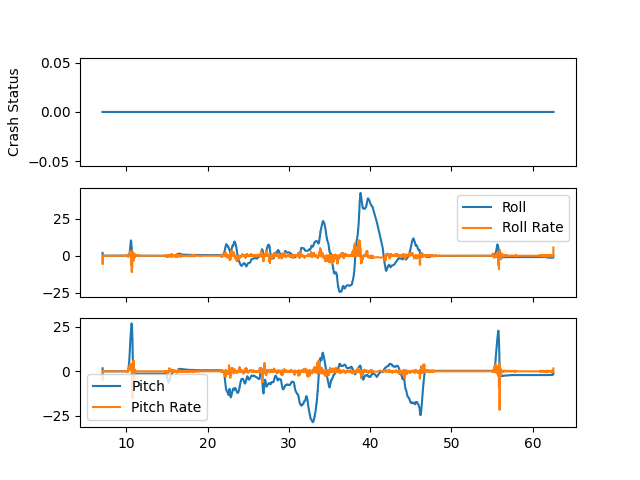

In [7]:
f, axs = plt.subplots(3, sharex=True)

axs[0].plot(t_clip, is_crash, label="Crashed?")
axs[0].set_ylabel("Crash Status")

axs[1].plot(t_clip, roll, label="Roll")
axs[1].plot(t_clip, p, label="Roll Rate")
axs[1].legend()

axs[2].plot(t_clip, pitch, label="Pitch")
axs[2].plot(t_clip, q, label="Pitch Rate")
axs[2].legend()

plt.show()

# Roll Control

## Inner Loop

<IPython.core.display.Javascript object>


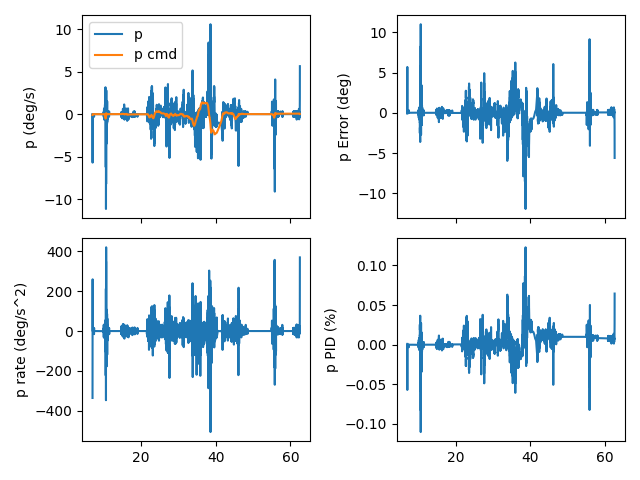

In [ ]:
plot_rate(t_clip, p_cmd, p, np.gradient(p, t_clip), p_pid, "p")

## Outer Loop

<IPython.core.display.Javascript object>


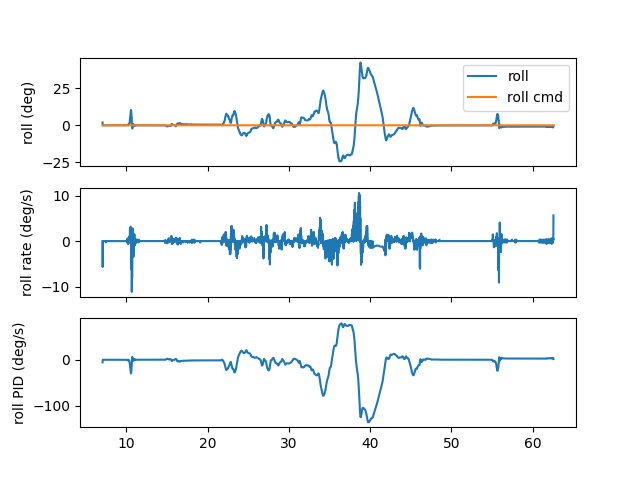

In [14]:
plot_angle(t_clip, roll_cmd, roll, p, np.degrees(roll_pid), label="roll")

# Pitch Control

## Inner Loop

<IPython.core.display.Javascript object>


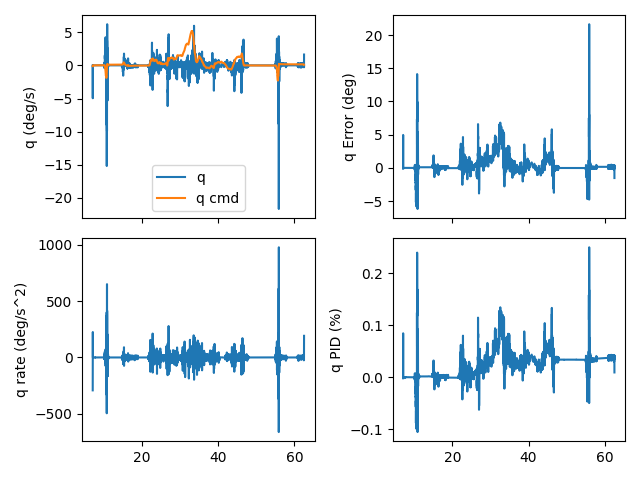

In [15]:
plot_rate(t_clip, q_cmd, q, np.gradient(q, t_clip), q_pid, "q")

## Outer Loop

<IPython.core.display.Javascript object>


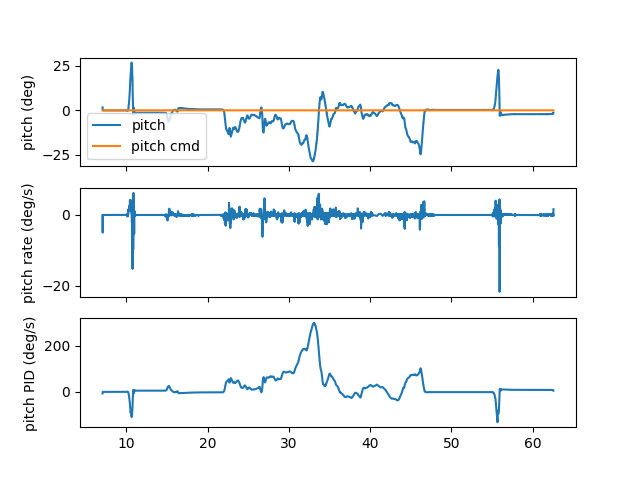

In [16]:
plot_angle(t_clip, pitch_cmd, pitch, q, np.degrees(pitch_pid), label="pitch")

# Yaw Control

## Inner Loop

<IPython.core.display.Javascript object>


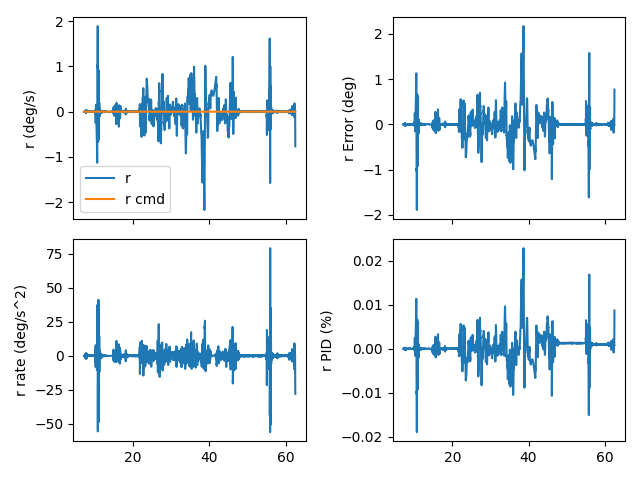

In [ ]:
plot_rate(t_clip, r_cmd, r, np.gradient(r, t_clip), r_pid, "r")

## Outer Loop

<IPython.core.display.Javascript object>


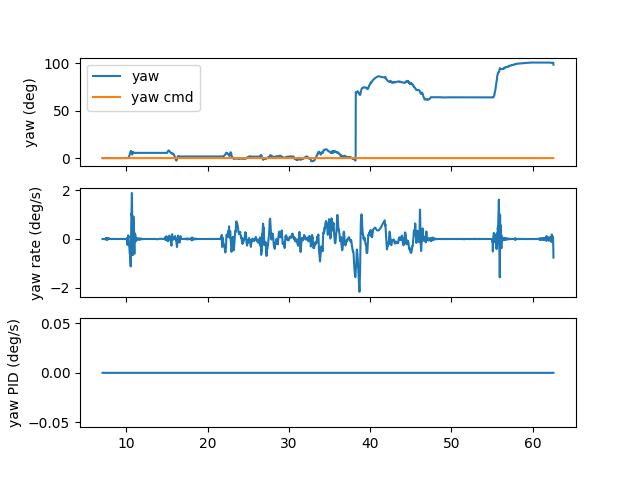

In [18]:
plot_angle(t_clip, yaw_cmd, yaw, r, yaw_pid, label="yaw")

# Motor Allocation

In [19]:
MAX_PWM = 2**14 - 1

def motor_pwm_to_pct(pwm, min_pwm_duty=0.051*MAX_PWM, max_pwm_duty=0.1*MAX_PWM):
    # Get PWM range in microseconds
    duty_range = max_pwm_duty - min_pwm_duty
    
    # Get the pwm distance from the lower limit
    pwm_offset = pwm - min_pwm_duty
    
    # Find the power
    power = pwm_offset / duty_range
    
    return power

<IPython.core.display.Javascript object>


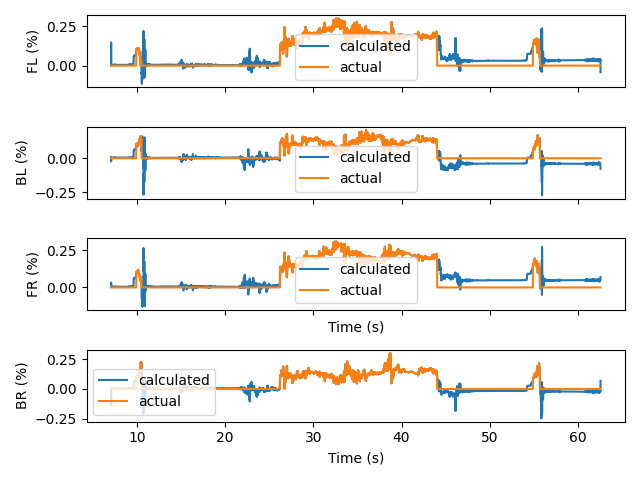

In [20]:
throttle_pct = throttle_np #* 0 + 0.5
front_left_out  = throttle_pct - p_pid + q_pid + r_pid
back_left_out   = throttle_pct - p_pid - q_pid - r_pid
front_right_out = throttle_pct + p_pid + q_pid - r_pid
back_right_out  = throttle_pct + p_pid - q_pid + r_pid

# Get actual motor powers
fl_power = power_np[idx_start:idx_end, 0]
bl_power = power_np[idx_start:idx_end, 1]
fr_power = power_np[idx_start:idx_end, 2]
br_power = power_np[idx_start:idx_end, 3]

# Plotting expected motor thrust allocation
f, axs = plt.subplots(4, sharex=True)

axs[0].plot(t_clip, front_left_out, label='calculated')
axs[0].plot(t_clip, fl_power, label='actual')
axs[0].set_ylabel("FL (%)")
axs[0].legend()

axs[1].plot(t_clip, back_left_out, label='calculated')
axs[1].plot(t_clip, bl_power, label='actual')
axs[1].set_ylabel("BL (%)")
axs[1].legend()

axs[2].plot(t_clip, front_right_out, label='calculated')
axs[2].plot(t_clip, fr_power, label='actual')
axs[2].set_ylabel("FR (%)")
axs[2].set_xlabel("Time (s)")
axs[2].legend()

axs[3].plot(t_clip, back_right_out, label='calculated')
axs[3].plot(t_clip, br_power, label='actual')
axs[3].set_ylabel("BR (%)")
axs[3].set_xlabel("Time (s)")
axs[3].legend()

f.tight_layout()

plt.show()

<IPython.core.display.Javascript object>


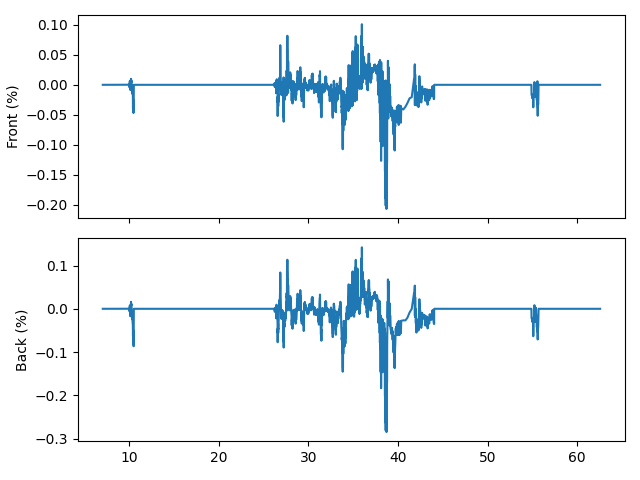

In [21]:
# Left - Right
front_delta = fl_power - fr_power
back_delta  = bl_power - br_power

# Plotting expected motor thrust allocation
f, axs = plt.subplots(2, sharex=True)

axs[0].plot(t_clip, front_delta)
axs[0].set_ylabel("Front (%)")

axs[1].plot(t_clip, back_delta)
axs[1].set_ylabel("Back (%)")

f.tight_layout()

plt.show()